<a href="https://colab.research.google.com/github/Muun-Muun/clusterd_sattelites_optimization/blob/main/impulse_CA_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [375]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm
from matplotlib.patches import Ellipse
import seaborn as sns
from matplotlib.lines import Line2D


plt.style.use('seaborn-v0_8-whitegrid')

In [258]:
# ---------------------- 함수 정의 ----------------------
def cw_propagate(delta_v, x0, n, t_array):
    """CW 방정식 기반 상대 위치 궤적 계산"""
    x0[3:] = delta_v
    positions = []

    for t in t_array:
        nt = n * t
        cos_nt, sin_nt = np.cos(nt), np.sin(nt)
        x = (4 - 3 * cos_nt) * x0[0] + sin_nt / n * x0[3] + 2 * (1 - cos_nt) / n * x0[4]
        y = 6 * (sin_nt - nt) * x0[0] + x0[1] + 2 * (cos_nt - 1) / n * x0[3] + (4 * sin_nt - 3 * nt) / n * x0[4]
        z = cos_nt * x0[2] + sin_nt / n * x0[5]
        positions.append([x, y, z])

    return np.array(positions)


def get_max_impact_delta_v(A, delta_v_max):
    ATA = A.T @ A
    eigvals, eigvecs = eig(ATA)
    v_opt = eigvecs[:, np.argmax(eigvals)]
    return v_opt / norm(v_opt) * delta_v_max


def get_min_pc_delta_v(cov, delta_v_max):
    eigvals, eigvecs = eig(cov)
    v_dir = eigvecs[:, np.argmin(eigvals)]
    v_dir = v_dir / norm(v_dir) * delta_v_max
    return np.array([v_dir[0], v_dir[1], 0.0])


def plot_covariance_ellipse(cov, ax, n_std=1.0, edgecolor='blue', **kwargs):
    """공분산 타원 그리기"""
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = Ellipse(xy=(0, 0), width=width, height=height, angle=angle,
                      edgecolor=edgecolor, facecolor='none', **kwargs)
    ax.add_patch(ellipse)


def draw_pc_contour(r_rel, C_rel, ax, range=(10, 10), HBR=1.0, density=10, alpha=0.5):
    """ 충돌확률 등고선 그리기 """
    C_inv = inv(C_rel)

    # 변수 계산
    eigvals, eigvecs = eigh(C_rel)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)
    sigma_x, sigma_y = np.sqrt(C_rel[0, 0]), np.sqrt(C_rel[1, 1])

    # 격자 생성
    x_vals = np.linspace(-range[0], range[0], 400)
    z_vals = np.linspace(-range[1], range[1], 400)
    X, Z = np.meshgrid(x_vals, z_vals)

    # Pc 계산
    d2_grid = np.einsum('...i,ij,...j->...', np.dstack((X, Z)), C_inv, np.dstack((X, Z)))
    pre_factor = HBR**2 / (2 * sigma_x * sigma_y)
    Pc = pre_factor * np.exp(-0.5 * d2_grid)

    levels = np.logspace(-10, -0, num=density)
    contour = ax.contour(X, Z, Pc, levels=levels, cmap='rainbow', norm=LogNorm(), alpha=alpha)
    ax.clabel(contour, inline=True, fmt=lambda v: f"{v:.0e}", fontsize=8)

    # 타원
    ellipse = Ellipse((0, 0), width=width, height=height, angle=angle,
                  edgecolor='blue', linestyle='--', lw=1.5,
                  facecolor='none', label='Covariance Ellipse (1σ)')


def plot_dv_arrow(ax, position, delta_v, scale=1.0, color='black', label=None):
    x0, y0 = position[0], position[1]
    dx, dy = delta_v[0] * scale, delta_v[1] * scale

    # 화살표 그리기
    ax.quiver(x0, y0, dx, dy,
              angles='xy', scale_units='xy', scale=1,
              color=color, width=0.005)

    # 범례 항목 생성 (화살표 모양으로)
    if label:
        legend_handle = Line2D([0], [0], color=color, lw=2, marker='>',
                               markersize=8, label=label)
        return legend_handle
    else:
        return None

In [368]:
# ---------------------- 초기 설정 ----------------------
n = 0.0011  # 평균 운동량 [rad/s]
delta_v_max = 5e-5  # delv 제약 [km/s]
HBR = 1
T = 2 * np.pi / n  # 한 궤도 주기 [s]
t_vals = np.linspace(0, 3*T, 1000)  # 3궤도주기

# del_v 위치전파 행렬
A = np.array([
    [0.5, 0.1, 0.0],
    [0.0, 0.3, 0.2]
])

# 공분산 행렬 (b-plane 상)
C_rel = np.array([
    [0.08, 0.1],
    [0.1, 0.5]
])

# 상대위치벡터
r_rel = np.array([0.01, 0.01])

# 초기 상태벡터 (CW)
x_0 = np.zeros((6,))
x_0[:2] =  r_rel

In [369]:
# ---------------------- Δv 계산 ----------------------
v_max_impact = get_max_impact_delta_v(A, delta_v_max)
v_min_pc = get_min_pc_delta_v(C_rel, delta_v_max)

traj_no_control = cw_propagate(0, x_0, n, t_vals)
traj_impact_max = cw_propagate(v_max_impact, x_0, n, t_vals)
traj_min_pc = cw_propagate(v_min_pc, x_0, n, t_vals)

print(0, norm(v_max_impact), v_max_impact)
print(0, norm(v_min_pc), v_min_pc)

0 5e-05 [4.72920756e-05 1.56906644e-05 4.15483289e-06]
0 5e-05 [-4.87706433e-05  1.10192718e-05  0.00000000e+00]


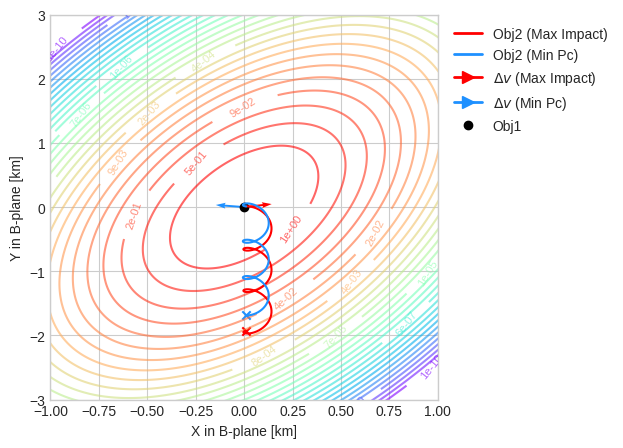

In [374]:
# ---------------------- 플롯 1: 궤적 ----------------------
xlim = 1.0
ylim = 3

fig1, ax1 = plt.subplots(figsize=(5,5))

# Pc Contour
draw_pc_contour(r_rel, C_rel, ax1, range=(2, 4), HBR=HBR, density=30, alpha=0.6)

# Max Impact Trajectory
ax1.plot(traj_impact_max[:, 0], traj_impact_max[:, 1], color='red', label='Max Impact Trajectory (Secondary Obj.)')
ax1.scatter(traj_impact_max[-1, 0], traj_impact_max[-1, 1], color='red', marker='x')
h_max = plot_dv_arrow(ax1, (0, 0), v_max_impact, scale=3000, color='red', label=r'$\Delta v$ (Max Impact)')

# Min Impact Trajectory
ax1.plot(traj_min_pc[:, 0], traj_min_pc[:, 1], color='dodgerblue', label='Min Pc Trajectory (Secondary Obj.)')
ax1.scatter(traj_min_pc[-1, 0], traj_min_pc[-1, 1], color='dodgerblue', marker='x')
h_min = plot_dv_arrow(ax1, (0, 0), v_min_pc, scale=3000, color='dodgerblue', label=r'$\Delta v$ (Min Pc)')

ax1.scatter(0,0,c='k', label='Primal Obj.')
ax1.set_xlabel(r'X in B-plane [km]')
ax1.set_ylabel(r'Y in B-plane [km]')
ax1.set_xlim(-xlim,xlim)
ax1.set_ylim(-ylim,ylim)
ax1.grid(True)
ax1.legend(handles=[
    Line2D([0], [0], color='red', lw=2, label='Obj2 (Max Impact)'),
    Line2D([0], [0], color='dodgerblue', lw=2, label='Obj2 (Min Pc)'),
    h_max, h_min, Line2D([0], [0], color='k', marker='o', linestyle='', label='Obj1')],
    loc='upper right',  ncol=1, bbox_to_anchor=(1.47, 1), )

plt.savefig('collision_avoidnace_bplane.png', dpi=300, bbox_inches='tight')